In [1]:
## Instakart market basket analysis                  #Amaresh hiremani 22

# Import statements

import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

# Reading datasets from external csv file
print('loading product prior')
pprior = pd.read_csv('order_products__prior.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading product train')
ptrain = pd.read_csv('order_products__train.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading orders')
orders = pd.read_csv('orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})

print('loading products')
products = pd.read_csv('products.csv', dtype={
        'product_id': np.uint16,
        'order_id': np.int32,
        'aisle_id': np.uint8,
        'department_id': np.uint8},
        usecols=['product_id', 'aisle_id', 'department_id'])
print('loaded completely')

loading product prior
loading product train
loading orders
loading products
loaded completely


In [2]:
# Finding the total purchase made by each user by user_id

# Joining orders with product prior to get product id 
print('add order info to priors')
orders.set_index('order_id', inplace=True, drop=False)
pprior = pprior.join(orders, on='order_id', rsuffix='_')
pprior.drop('order_id_', inplace=True, axis=1)

# Joining orders with product train to get product id 
print('add order info to train')
ptrain = ptrain.join(orders, on='order_id', rsuffix='_')
ptrain.drop('order_id_', inplace=True, axis=1)

# Reduce the user id to 500 to train 
ptrain = ptrain.loc[ptrain['user_id'] <= 500]
ptrain = ptrain

# Reduce the user id to 500 to test 
pprior = pprior.loc[pprior['user_id'] <= 500]

user = pd.DataFrame()

# Total number of order by users
user['total_products'] = pprior.groupby('user_id').size().astype(np.int16)

# All product_id of products purchased by users
user['products_all'] = pprior.groupby('user_id')['product_id'].apply(set)

# Distinct no of product user purchased
user['total_distinct_items'] = (user.products_all.map(len)).astype(np.int16)

# Finding average days between subsequent orders placed by same user from orders dataframe and no of orders
usr = pd.DataFrame()
usr['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
usr['nb_orders'] = orders.groupby('user_id').size().astype(np.int16)

# Joining the user with usr by user_id
user = user.join(usr)
del usr
user['average_basket'] = (user.total_products / user.nb_orders).astype(np.float32)
print('number of users:', user.shape[0])

add order info to priors
add order info to train
number of users: 500


In [3]:
# Computing the products details

print('computing product features')
prods = pd.DataFrame()
prods['orders'] = pprior.groupby(pprior.product_id).size().astype(np.int32)
prods['reorders'] = pprior['reordered'].groupby(pprior.product_id).sum().astype(np.float32)
prods['reorder_rate'] = (prods.reorders / prods.orders).astype(np.float32)
products = products.join(prods, on='product_id')
products.set_index('product_id', drop=False, inplace=True)
del prods

computing product features


In [4]:
### userXproduct features

print('compute userXproduct features by encoding this is long...')
pprior['user_product'] = pprior.product_id + pprior.user_id * 100000
d= dict()
for row in pprior.itertuples():
    z = row.user_product
    if z not in d:
        d[z] = (1,
                (row.order_number, row.order_id),
                row.add_to_cart_order)
    else:
        d[z] = (d[z][0] + 1,
                max(d[z][1], (row.order_number, row.order_id)),
                d[z][2] + row.add_to_cart_order)
        
print('to dataframe (less memory)')
userXproduct = pd.DataFrame.from_dict(d, orient='index')
del d
userXproduct.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']
userXproduct.nb_orders = userXproduct.nb_orders.astype(np.int16)
userXproduct.last_order_id = userXproduct.last_order_id.map(lambda x: x[1]).astype(np.int32)
userXproduct.sum_pos_in_cart = userXproduct.sum_pos_in_cart.astype(np.int16)
print('user X product f', len(userXproduct))

del pprior

compute userXproduct features by encoding this is long...
to dataframe (less memory)
user X product f 32233


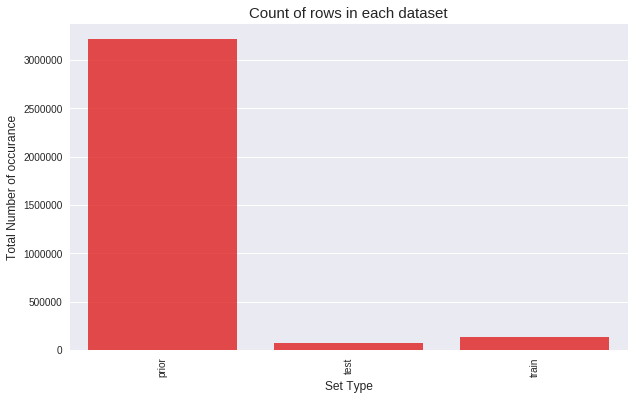

In [5]:
#different kind of evaluation set presrent in orders

count = orders.eval_set.value_counts()

plt.figure(figsize=(10,6))
sns.barplot(count.index, count.values, alpha=0.8, color='red')
plt.ylabel('Total Number of occurance', fontsize=12)
plt.xlabel('Set Type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show() 

In [6]:
### train / test orders ###
print('split orders : train, test')
test_orders = orders[orders.eval_set == 'test']
train_orders = orders[orders.eval_set == 'train']

ptrain = ptrain[['order_id','product_id','add_to_cart_order','reordered']]
ptrain.set_index(['order_id', 'product_id'], inplace=True, drop=False)

split orders : train, test


In [7]:
train_orders = train_orders.loc[train_orders['user_id']<=500]
test_orders = test_orders.loc[test_orders['user_id']<=500]

In [8]:
### build list of candidate products to reorder, with features ###

def features(selected_orders, labels_given=False):
    print('build candidate list')
    order_list = []
    product_list = []
    labels = []
    i=0
    for row in selected_orders.itertuples():
        i+=1
        if i%100 == 0: print('order row',i)
        order_id = row.order_id
        user_id = row.user_id
        user_products = user.products_all[user_id]
        product_list += user_products
        order_list += [order_id] * len(user_products)
        if labels_given:
            labels += [(order_id, product) in ptrain.index for product in user_products]
        
    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    
    print('user related features')
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(user.nb_orders)
    df['user_total_items'] = df.user_id.map(user.total_products)
    df['total_distinct_items'] = df.user_id.map(user.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(user.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(user.average_basket)
    
    print('order related features')
    # df['dow'] = df.order_id.map(orders.order_dow)
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders
    
    print('product related features')
    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products.reorders)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    print('user_X_product related features')
    df['z'] = df.user_id * 100000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_orders_ratio'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number)
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
    #df['UP_same_dow_as_last_order'] = df.UP_last_order_id.map(orders.order_dow) == \
    #                                              df.order_id.map(orders.order_dow)

    df.drop(['UP_last_order_id', 'z'], axis=1, inplace=True)
    print(df.dtypes)
    print(df.memory_usage())
    return (df, labels)

In [9]:
df_train, labels = features(train_orders, labels_given=True)

f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last',
       'UP_delta_hour_vs_last'] # 'dow', 'UP_same_dow_as_last_order'


print('formating for lgb')
d_train = lgb.Dataset(df_train[f_to_use],
                      label=labels,
                      categorical_feature=['aisle_id', 'department_id'])  # , 'order_hour_of_day', 'dow'
del df_train

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}
ROUNDS = 100

build candidate list
order row 100
order row 200
order row 300
user related features
order related features
product related features
user_X_product related features
order_id                              int32
product_id                            int32
user_total_orders                     int16
user_total_items                      int16
total_distinct_items                  int16
user_average_days_between_orders    float32
user_average_basket                 float32
order_hour_of_day                      int8
days_since_prior_order              float32
days_since_ratio                    float32
aisle_id                              uint8
department_id                         uint8
product_orders                        int32
product_reorders                    float32
product_reorder_rate                float32
UP_orders                             int16
UP_orders_ratio                     float32
UP_average_pos_in_cart              float32
UP_reorder_rate                     float32

In [10]:
# Training and Testing for given datasets

print('light GBM train :-)')
bst = lgb.train(params, d_train, ROUNDS)
# lgb.plot_importance(bst, figsize=(9,20))
del d_train

### build candidates list for test ###

df_test, _ = features(test_orders)

print('light GBM predict')
preds = bst.predict(df_test[f_to_use])

df_test['pred'] = preds

TRESHOLD = 0.22  # guess, should be tuned with crossval on a subset of train data

d = dict()
for row in df_test.itertuples():
    if row.pred > TRESHOLD:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('sub.csv', index=False)

light GBM train :-)


/home/amaresh/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:986: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


build candidate list
order row 100
user related features
order related features
product related features
user_X_product related features
order_id                              int32
product_id                            int32
user_total_orders                     int16
user_total_items                      int16
total_distinct_items                  int16
user_average_days_between_orders    float32
user_average_basket                 float32
order_hour_of_day                      int8
days_since_prior_order              float32
days_since_ratio                    float32
aisle_id                              uint8
department_id                         uint8
product_orders                        int32
product_reorders                    float32
product_reorder_rate                float32
UP_orders                             int16
UP_orders_ratio                     float32
UP_average_pos_in_cart              float32
UP_reorder_rate                     float32
UP_orders_since_last       